In [66]:
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import random
!jupyter nbconvert --to script clone_notebook.ipynb

[NbConvertApp] Converting notebook clone_notebook.ipynb to script
[NbConvertApp] Writing 4799 bytes to clone_notebook.py


In [48]:
UDACITY_DATA = './data/'
MY_DATA = './SimulationData/'

# data_path = UDACITY_DATA
data_path = MY_DATA

def get_image(data_folder, source_path):
    filename = source_path.split('/')[-1]
    current_path = data_folder + 'IMG/' + filename
    image = cv2.imread(current_path)
    # Convert to RGB as drive.py uses RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

images = []
steering_angles  = []
with open(data_path + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    # Skip headers in Udacity Data
    if data_path == UDACITY_DATA:
        next(reader)

    for line in reader:
        image_centre = get_image(data_path, line[0])
        image_left = get_image(data_path, line[1])
        image_right = get_image(data_path, line[2])
        
        # Add a correction angle for the left and right cameras
        angle_centre = float(line[3])
        correction = 0.1
        angle_left = angle_centre + correction
        angle_right = angle_centre - correction

        # Skip roughly 1/2 of centre angle training data
        if angle_centre < 0.05 and random.randint(0,1) == 0:
            continue

        images.extend([image_centre, image_left, image_right])
        steering_angles.extend([angle_centre, angle_left, angle_right])
        # break

In [49]:
# Data Augmentation
augmented_images = []
augmented_angles = []
for image, angle in zip(images, steering_angles):
    augmented_images.append(image)
    augmented_angles.append(angle)
    
    # Add flipped images to double size of dataset and remove aymmetric bias
    # from track (biased left as track is anticlockwise)
    augmented_images.append(cv2.flip(image, 1))
    augmented_angles.append(angle * -1.0)

images = augmented_images
steering_angles = augmented_angles

In [50]:
X_train = np.array(images)
y_train = np.array(steering_angles)

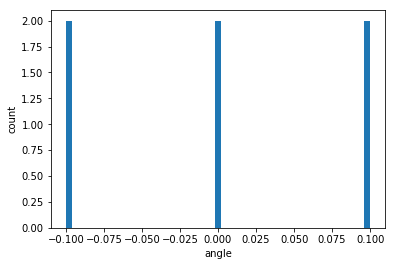

In [63]:
# Visualise the data

# Steering angle distribution
n, bins, patches = plt.hist(y_train, 51)
plt.xlabel('angle')
plt.ylabel('count')
plt.savefig('./writeup/original_distribution.jpg', bbox_inches='tight')
plt.show()

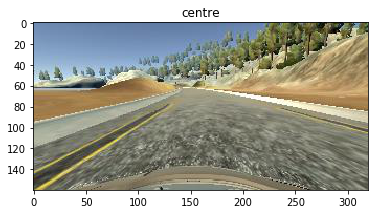

In [65]:
plt.imshow(X_train[0])
plt.title("centre")
plt.savefig('./writeup/original.jpg', bbox_inches='tight')

(160, 320, 3)
(110, 320, 3)


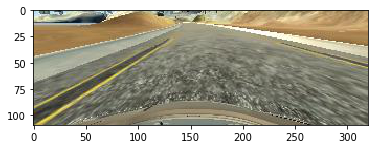

In [53]:
# Visualise the preprocessing
# (put the functions here and reference in the keras layers later)
def normalise(img):
    return img / 255.0 - 0.5

def crop(img, l=0, r=0, t=0, b=0):
    h, w, col = img.shape
    return img[t:h-b, l:w-r, :]

test_img = X_train[0]
print(test_img.shape)
test_img = crop(test_img, t=50, b=10)
print(test_img.shape)
plt.imshow(test_img)

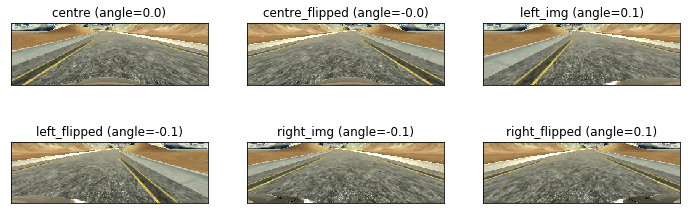

In [64]:
sample_img_names = [
    "centre",
    "centre_flipped",
    "left_img",
    "left_flipped",
    "right_img",
    "right_flipped"
]

fig, axes = plt.subplots(2, 3, figsize=(12, 4), subplot_kw={'xticks': [], 'yticks': []})
for i, name in enumerate(sample_img_names):
    axes.flat[i].imshow(crop(X_train[i], t=50, b=10))
    axes.flat[i].set_title(name + " (angle=" + str(y_train[i]) + ")")

fig.savefig('./writeup/augmentations.jpg', bbox_inches='tight')

In [20]:
# MODEL = 'lenet'
MODEL = 'nvidia'

model = Sequential()

# Preprocessing layers
model.add(Cropping2D(cropping=((50,10), (0,0)), input_shape=(160, 320, 3)))
model.add(Lambda(normalise))
    
if MODEL == 'lenet':
    model.add(Convolution2D(6, 5, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(84))
    model.add(Dense(1))
elif MODEL == 'nvidia':
    model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))

In [21]:
# Training
checkpointer = ModelCheckpoint(filepath='weights.{epoch:02d}.hdf5', monitor='val_loss')
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.2,
                    shuffle=True, nb_epoch=5, callbacks=[checkpointer])
model.save('model.h5')

Train on 13848 samples, validate on 3462 samples
Epoch 1/5
13848/13848 [==============================] - 38s - loss: 0.0303 - val_loss: 0.0102
Epoch 2/5
13848/13848 [==============================] - 35s - loss: 0.0202 - val_loss: 0.0092
Epoch 3/5
13848/13848 [==============================] - 35s - loss: 0.0157 - val_loss: 0.0110
Epoch 4/5
13848/13848 [==============================] - 35s - loss: 0.0139 - val_loss: 0.0073
Epoch 5/5
13848/13848 [==============================] - 35s - loss: 0.0101 - val_loss: 0.0086


dict_keys(['loss', 'val_loss'])


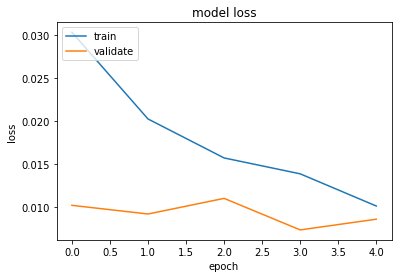

In [22]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()